# GeoPandas Weather Visualization
This notebook fetches weather data for Encina, Point Loma, and South Bay, visualizes it on a map of **San Diego County**, and includes interactive time sliders.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import osmnx as ox
from datetime import datetime, timedelta
import openmeteo_requests
import requests_cache
from retry_requests import retry
from scipy.stats import pearsonr
import os
import numpy as np

cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=3, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)


In [2]:
locations = {
    "Encina": (33.1387, -117.3258),
    "Point Loma": (32.6840, -117.2400),
    "South Bay": (32.5881, -117.0330)
}

gdf = gpd.GeoDataFrame(
    {"location": list(locations.keys())},
    geometry=gpd.points_from_xy([lon for _, lon in locations.values()],
                                [lat for lat, _ in locations.values()]),
    crs="EPSG:4326"
)
gdf

,location,geometry
0,Encina,POINT (-117.3258 33.1387)
1,Point Loma,POINT (-117.24 32.684)
2,South Bay,POINT (-117.033 32.5881)


In [3]:
def fetch_weather(lat, lon, start=None, end=None):
    if start is None:
        start = (datetime.utcnow() - timedelta(days=2)).strftime("%Y-%m-%d")
    if end is None:
        end = datetime.utcnow().strftime("%Y-%m-%d")

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": ["temperature_2m", "relative_humidity_2m", "wind_speed_10m"],
        "start_date": start,
        "end_date": end,
        "timezone": "UTC"
    }

    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()

    time_start = hourly.Time()
    time_end = hourly.TimeEnd()
    interval = hourly.Interval()

    times = pd.date_range(
        start=pd.to_datetime(time_start, unit="s"),
        end=pd.to_datetime(time_end, unit="s"),
        freq=pd.Timedelta(seconds=interval),
        inclusive="left"
    )

    temp = hourly.Variables(0).ValuesAsNumpy()
    humidity = hourly.Variables(1).ValuesAsNumpy()
    wind = hourly.Variables(2).ValuesAsNumpy()

    min_len = min(len(times), len(temp), len(humidity), len(wind))
    return pd.DataFrame({
        "time": times[:min_len],
        "temperature": temp[:min_len],
        "humidity": humidity[:min_len],
        "wind_speed": wind[:min_len]
    })


In [4]:
weather_data = {}
for loc, (lat, lon) in locations.items():
    df = fetch_weather(lat, lon)
    df["location"] = loc
    weather_data[loc] = df

combined = pd.concat(weather_data.values(), ignore_index=True)
combined.head()

,time,temperature,humidity,wind_speed,location
0,2025-12-01 00:00:00,16.093000,76.0,6.519877,Encina
1,2025-12-01 01:00:00,15.292999,76.0,8.587338,Encina
2,2025-12-01 02:00:00,13.393000,79.0,6.120000,Encina
3,2025-12-01 03:00:00,14.193000,78.0,5.904439,Encina
4,2025-12-01 04:00:00,15.243000,77.0,1.440000,Encina


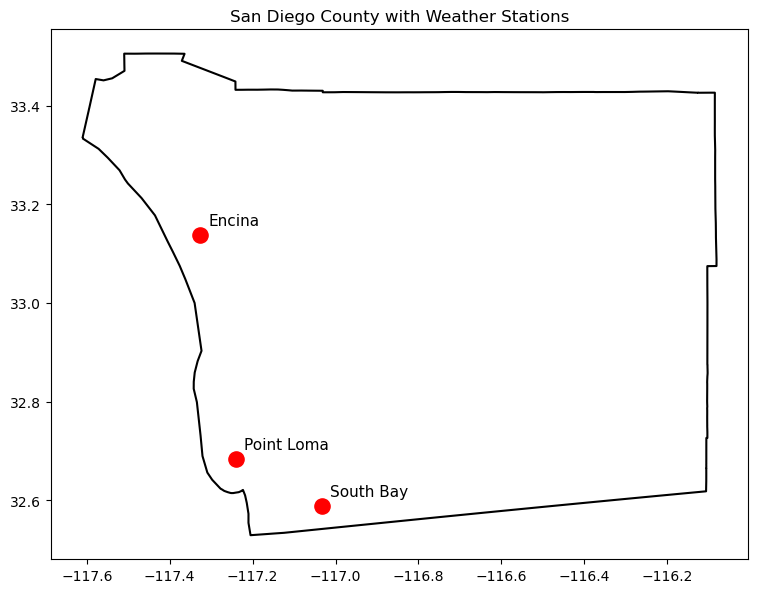

In [5]:
county = ox.geocode_to_gdf("San Diego County, California, USA").to_crs(4326)

fig, ax = plt.subplots(figsize=(9,9))
county.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)
gdf.plot(ax=ax, color="red", markersize=120)

for idx, row in gdf.iterrows():
    ax.text(row.geometry.x + 0.02, row.geometry.y + 0.02, row["location"], fontsize=11)

ax.set_title("San Diego County with Weather Stations")
plt.show()

In [6]:
combined['time'] = pd.to_datetime(combined['time'])
timestamps = sorted(combined['time'].unique())

def plot_spatial(timestamp, variable):
    snapshot = combined[combined['time'] == timestamp]
    spatial = gdf.merge(snapshot, on='location')

    fig, ax = plt.subplots(figsize=(9,9))
    county.boundary.plot(ax=ax, edgecolor='black', linewidth=1.2)
    spatial.plot(column=variable, ax=ax, cmap='coolwarm', legend=True, markersize=200)

    for i, row in spatial.iterrows():
        ax.text(row.geometry.x+0.02, row.geometry.y+0.02, row["location"], fontsize=10)

    ax.set_title(f"{variable.title()} at {timestamp}")
    plt.show()

time_slider = widgets.SelectionSlider(options=timestamps, description="Time:")
var_dropdown = widgets.Dropdown(options=["temperature", "humidity", "wind_speed"], description="Variable:")

widgets.interact(plot_spatial, timestamp=time_slider, variable=var_dropdown)


interactive(children=(SelectionSlider(description='Time:', options=(Timestamp('2025-12-01 00:00:00'), Timestam…

<function __main__.plot_spatial(timestamp, variable)>

             Mean viral gene copies/L      smoothed    zscore
Sample_Date                                                  
2022-02-07               4.361033e+06           NaN  5.391179
2022-02-08               4.061033e+06           NaN  4.935100
2022-02-09               4.131344e+06           NaN  5.041991
2022-02-10               3.639579e+06  3.693950e+06  4.294380
2022-02-11               3.147814e+06  3.552235e+06  3.546769
...                               ...           ...       ...
2025-10-29               4.035110e+05  3.930990e+05 -0.625288
2025-10-30               4.911540e+05  3.846631e+05 -0.492048
2025-10-31               4.345687e+05           NaN -0.578073
2025-11-01               3.779833e+05           NaN -0.664097
2025-11-02               3.213980e+05           NaN -0.750122

[1365 rows x 3 columns]


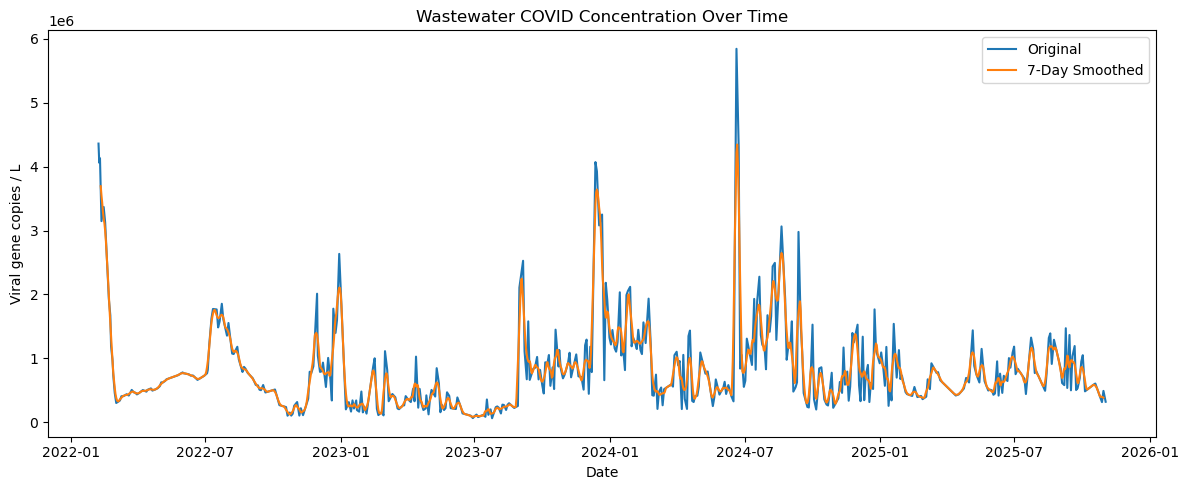

In [7]:
def load_wastewater(csv_path):
    df = pd.read_csv(csv_path)
    df['Sample_Date'] = pd.to_datetime(df['Sample_Date'])
    df = df.sort_values('Sample_Date')
    df = df.set_index('Sample_Date')
    return df


def interpolate_daily(df):
    df_daily = df.resample('D').interpolate(method='linear')
    return df_daily

def smooth_signal(df_daily):
    df_daily['smoothed'] = df_daily.iloc[:, 0].rolling(7, center=True).mean()
    return df_daily

def normalize(df_daily):
    col = df_daily.columns[0]
    df_daily['zscore'] = (df_daily[col] - df_daily[col].mean()) / df_daily[col].std()
    return df_daily

def process_wastewater(csv_path):
    """
    Steps performed:
    - Load CSV 
    - Convert to daily data 
    - Smooth data with 7-day rolling average
    - Add z-score 
    """
    df = load_wastewater(csv_path)
    df_daily = interpolate_daily(df)
    df_daily = smooth_signal(df_daily)
    df_daily = normalize(df_daily)
    return df_daily

def plot_data(df_daily):
    plt.figure(figsize=(12, 5))
    plt.plot(df_daily.index, df_daily.iloc[:, 0], label='Original')
    plt.plot(df_daily.index, df_daily['smoothed'], label='7-Day Smoothed')
    plt.title('Wastewater COVID Concentration Over Time')
    plt.xlabel('Date')
    plt.ylabel('Viral gene copies / L')
    plt.legend()
    plt.tight_layout()
    plt.show()


file_path = "Wastewater_Data/SouthBay_sewage_qPCR_Modified.csv"
df_processed = process_wastewater(file_path)

df_processed.to_csv("SouthBay_sewage_qPCR_Modified.csv")

print(df_processed)
plot_data(df_processed)


Encina Corelation Results:
CORRELATION RESULTS:
Z-score vs MIN temp: 0.0332
Z-score vs MAX temp: 0.1619
Z-score vs AVG temp: 0.1019



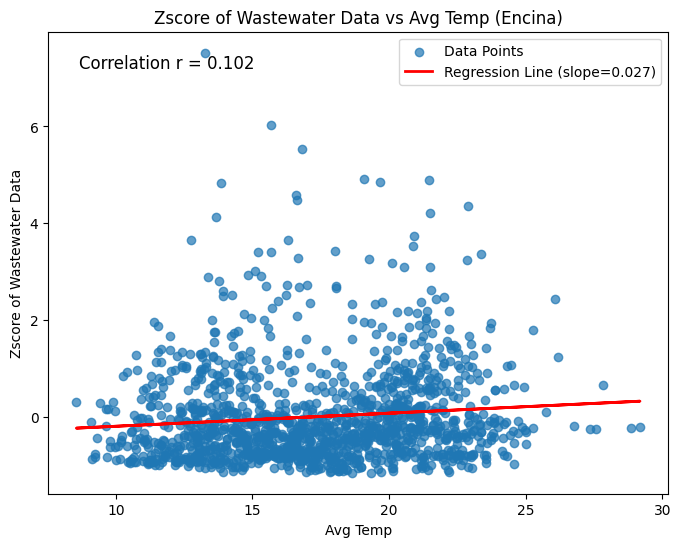

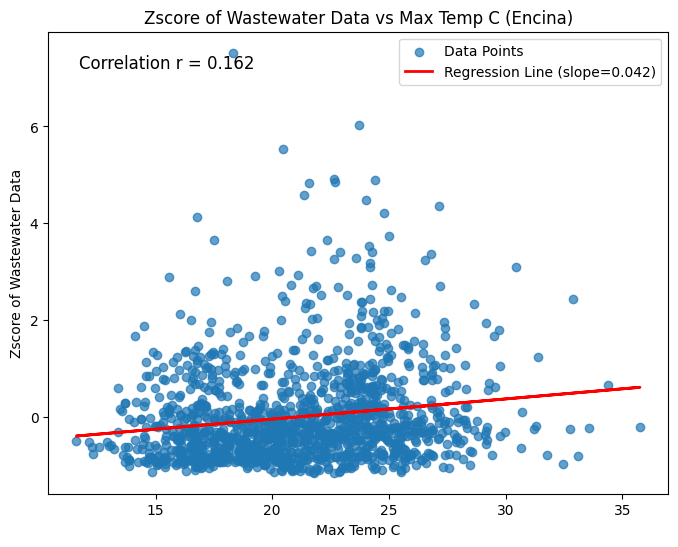

Encina Weekly Results:
WEEKLY (7-day averaged) CORRELATION:
Weekly Z-score vs Weekly MIN temp: 0.0531
Weekly Z-score vs Weekly MAX temp: 0.1947
Weekly Z-score vs Weekly AVG temp: 0.1229



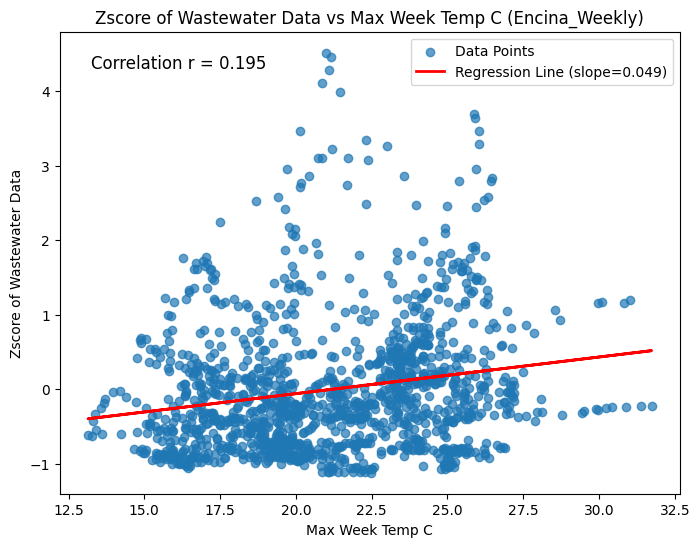

PointLoma Corelation Results:
CORRELATION RESULTS:
Z-score vs MIN temp: -0.0326
Z-score vs MAX temp: 0.0241
Z-score vs AVG temp: -0.0062



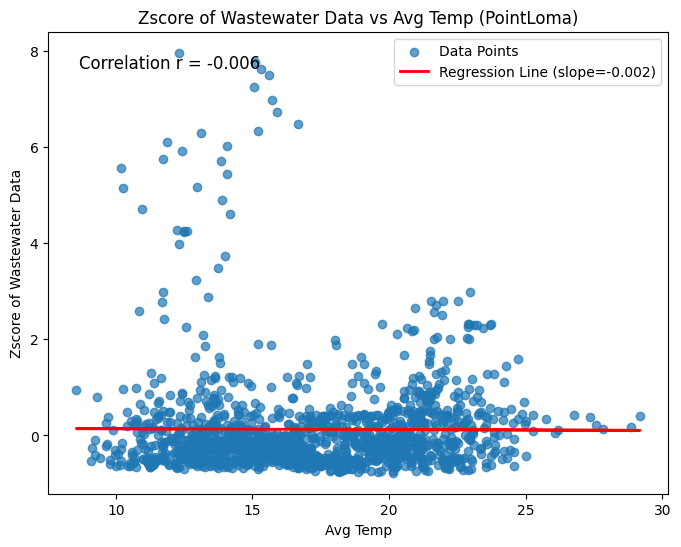

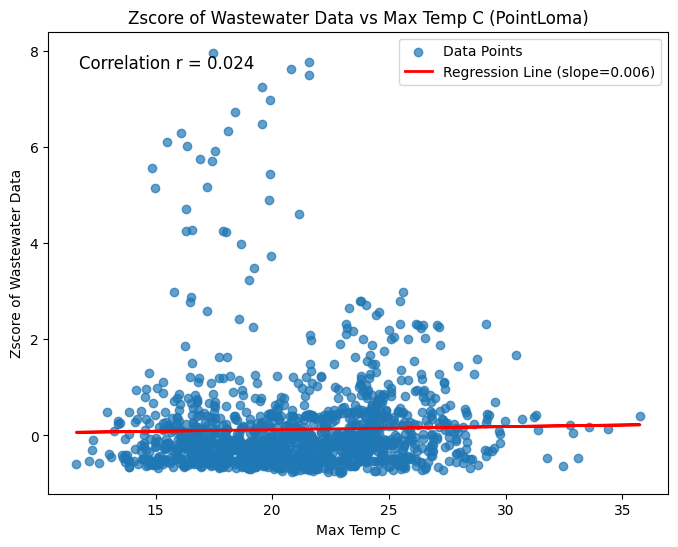

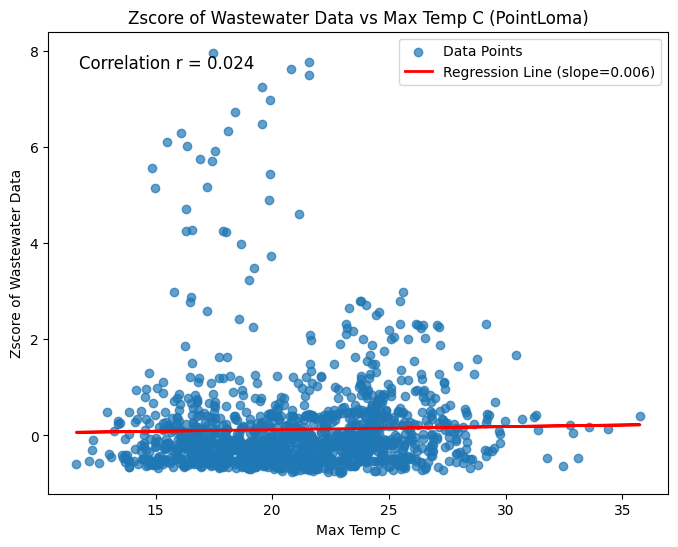

PointLoma Weekly Results:
WEEKLY (7-day averaged) CORRELATION:
Weekly Z-score vs Weekly MIN temp: -0.0186
Weekly Z-score vs Weekly MAX temp: 0.0510
Weekly Z-score vs Weekly AVG temp: 0.0138



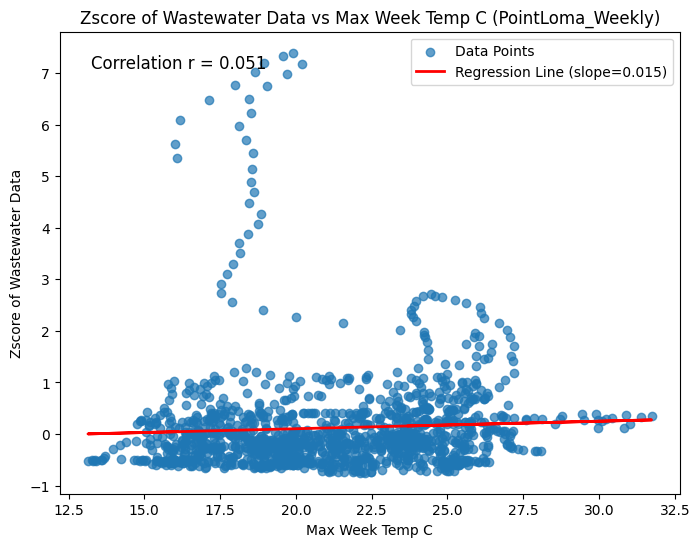

South Bay Corelation Results:
CORRELATION RESULTS:
Z-score vs MIN temp: 0.0409
Z-score vs MAX temp: 0.1130
Z-score vs AVG temp: 0.0813



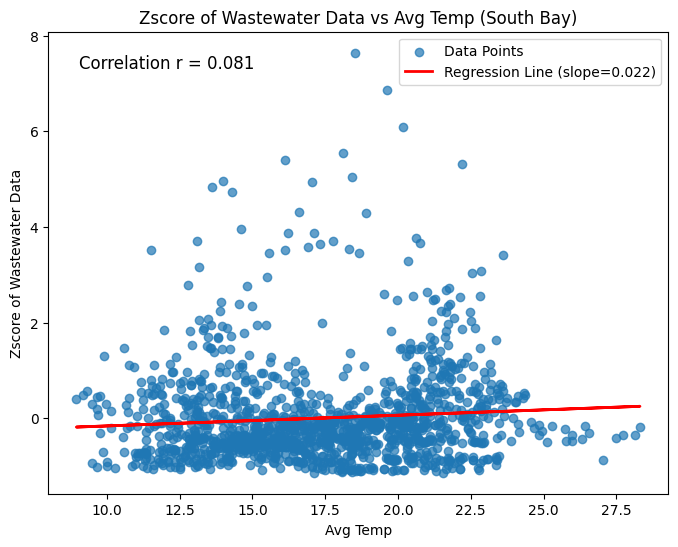

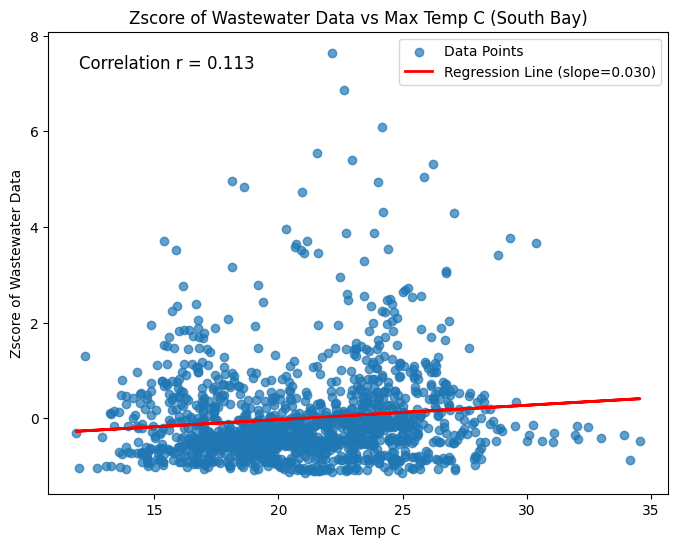

South Bay Weekly Results:
WEEKLY (7-day averaged) CORRELATION:
Weekly Z-score vs Weekly MIN temp: 0.0562
Weekly Z-score vs Weekly MAX temp: 0.1435
Weekly Z-score vs Weekly AVG temp: 0.1007



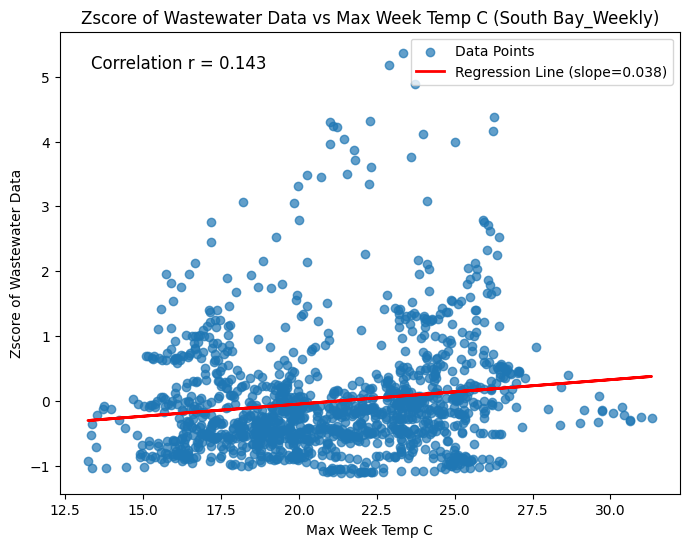

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
def load_wastewater(path):

    df = pd.read_csv(path)
    df['Sample_Date'] = pd.to_datetime(df['Sample_Date'])
    df = df.set_index('Sample_Date')
    return df

def load_weather(path):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    df.index = df.index.tz_localize(None)   
    df.index = df.index.normalize()         
    return df


def merge_and_correlate(wastewater_csv, weather_csv):
    '''
    Merges wastewater and weather datasets and computes correlations between Z-scores and temperature.
    '''
    wastewater_data = load_wastewater(wastewater_csv)
    weather_data = load_weather(weather_csv)

    df = wastewater_data.join(weather_data, how='inner')

    df['avg_temp'] = (df['min_temp_c'] + df['max_temp_c']) / 2

    corr_min = df['zscore'].corr(df['min_temp_c'])
    corr_max = df['zscore'].corr(df['max_temp_c'])
    corr_avg = df['zscore'].corr(df['avg_temp'])

    print("CORRELATION RESULTS:")
    print(f"Z-score vs MIN temp: {corr_min:.4f}")
    print(f"Z-score vs MAX temp: {corr_max:.4f}")
    print(f"Z-score vs AVG temp: {corr_avg:.4f}")
    print("================================\n")

    return df

def weekly_correlation(wastewater_data, weather_data, window=7):
    """
    Computes 7-day rolling-average correlations between wastewater z-scores
    and weather
    """

    df = wastewater_data.join(weather_data, how="inner")

    df["avg_temp"] = (df["min_temp_c"] + df["max_temp_c"]) / 2

    df = df.sort_index()

    df["z_week"]   = df["zscore"].rolling(window=window).mean()
    df["min_week_temp_c"] = df["min_temp_c"].rolling(window=window).mean()
    df["max_week_temp_c"] = df["max_temp_c"].rolling(window=window).mean()
    df["avg_week_temp_c"] = df["avg_temp"].rolling(window=window).mean()

    df2 = df.dropna()

    corr_min = df2["z_week"].corr(df2["min_week_temp_c"])
    corr_max = df2["z_week"].corr(df2["max_week_temp_c"])
    corr_avg = df2["z_week"].corr(df2["avg_week_temp_c"])

    print("WEEKLY (7-day averaged) CORRELATION:")
    print(f"Weekly Z-score vs Weekly MIN temp: {corr_min:.4f}")
    print(f"Weekly Z-score vs Weekly MAX temp: {corr_max:.4f}")
    print(f"Weekly Z-score vs Weekly AVG temp: {corr_avg:.4f}")
    print("================================================\n")

    return df2



def plot_correlation(df, x_column, y_column, location_name="location"):
    """
    Creates a scatter plot with regression line, labels it,
    labels correlation, and saves as PNG.
    """

    x = df[x_column].values
    y = df[y_column].values

    # Compute regression line
    slope, intercept = np.polyfit(x, y, 1)
    reg_line = slope * x + intercept

    # Compute correlation
    corr = df[x_column].corr(df[y_column])

    # Create plot
    plt.figure(figsize=(8, 6))

    # Scatter
    plt.scatter(x, y, alpha=0.7, label="Data Points")

    # Regression line (red)
    plt.plot(
        x,
        reg_line,
        linewidth=2,
        color='red',
        label=f"Regression Line (slope={slope:.3f})"
    )

    #X and Y labels
    pretty_x = x_column.replace("_", " ").title()
    pretty_y = "Zscore of Wastewater Data"

    plt.xlabel(pretty_x)
    plt.ylabel(pretty_y)
    plt.title(f"{pretty_y} vs {pretty_x} ({location_name})")

    # label correlation on graph
    plt.text(
        0.05, 0.95,
        f"Correlation r = {corr:.3f}",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top'
    )

    plt.legend()

    #script_dir = os.getcwd()
    #filename = os.path.join(
        #script_dir,
        #f"{location_name.replace(' ', '_')}_{y_column}_vs_{x_column}.png"
    #)

    #plt.savefig(filename, dpi=300, bbox_inches="tight")
    #print(f"Plot saved as: {filename}\n")
    
    plt.show()
    plt.close()

print("Encina Corelation Results:")
df=merge_and_correlate("Wastewater_Data/Encina_sewage_qPCR_Modified.csv","weather_Encina.csv")

plot_correlation(df, "avg_temp", "zscore", location_name="Encina")
plot_correlation(df, "max_temp_c", "zscore", location_name="Encina")

print("Encina Weekly Results:")
df2=weekly_correlation(
    load_wastewater("Wastewater_Data/Encina_sewage_qPCR_Modified.csv"),
    load_weather("weather_Encina.csv")
)
plot_correlation(df2, "max_week_temp_c", "z_week", location_name="Encina_Weekly")


print("PointLoma Corelation Results:")
df=merge_and_correlate("Wastewater_Data/PointLoma_sewage_qPCR_Modified.csv","weather_Point Loma.csv")
plot_correlation(df, "avg_temp", "zscore", location_name="PointLoma")
plot_correlation(df, "max_temp_c", "zscore", location_name="PointLoma")
plot_correlation(df, "max_temp_c", "zscore", location_name="PointLoma")

print("PointLoma Weekly Results:")
df2=weekly_correlation(
    load_wastewater("Wastewater_Data/PointLoma_sewage_qPCR_Modified.csv"),
    load_weather("weather_Point Loma.csv")
)
plot_correlation(df2, "max_week_temp_c", "z_week", location_name="PointLoma_Weekly")


print("South Bay Corelation Results:")
df=merge_and_correlate("Wastewater_Data/SouthBay_sewage_qPCR_Modified.csv","weather_South Bay.csv")

plot_correlation(df, "avg_temp", "zscore", location_name="South Bay")
plot_correlation(df, "max_temp_c", "zscore", location_name="South Bay")

print("South Bay Weekly Results:")
df2=weekly_correlation(
    load_wastewater("Wastewater_Data/SouthBay_sewage_qPCR_Modified.csv"),
    load_weather("weather_South Bay.csv")
)

plot_correlation(df2, "max_week_temp_c", "z_week", location_name="South Bay_Weekly")


In [9]:
def load_wastewater(path):
    """
    Load wastewater data and prepare for merging.
    """
    df = pd.read_csv(path)
    df['Sample_Date'] = pd.to_datetime(df['Sample_Date'])
    df = df.set_index('Sample_Date')
    return df

def load_weather(path):
    """
    Load weather data and prepare for merging.
    """
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    
    # Remove timezone and normalize to date only
    df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    return df

def merge_and_correlate(wastewater_csv, weather_csv, location_name):
    """
    Merges wastewater and weather datasets and computes correlations 
    between viral gene copies and humidity.
    """
    wastewater_data = load_wastewater(wastewater_csv)
    weather_data = load_weather(weather_csv)
    
    # Merge on date index
    df = wastewater_data.join(weather_data, how='inner')
    
    # Extract relevant columns
    df = df[['Mean viral gene copies/L', 'avg_humidity_%']].dropna()
    
    if len(df) == 0:
        print(f"No matching data found for {location_name}")
        return None, None
    
    # Calculate correlation
    correlation, p_value = pearsonr(df['avg_humidity_%'], df['Mean viral gene copies/L'])
    
    print(f"\n{location_name} Correlation Results:")
    print(f"Humidity vs Viral Gene Copies/L: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Number of data points: {len(df)}")
    print("=" * 50)
    
    return df, correlation

def plot_correlation(df, location_name, correlation):
    """
    Create scatter plot with humidity on x-axis and viral gene copies on y-axis.
    """
    if df is None or len(df) == 0:
        return
    
    plt.figure(figsize=(10, 6))
    plt.scatter(df['avg_humidity_%'], df['Mean viral gene copies/L'], 
                alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Add trend line
    z = np.polyfit(df['avg_humidity_%'], df['Mean viral gene copies/L'], 1)
    p = np.poly1d(z)
    plt.plot(df['avg_humidity_%'], p(df['avg_humidity_%']), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend line (r={correlation:.3f})')
    
    plt.xlabel('Average Humidity (%)', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Viral Gene Copies/L', fontsize=12, fontweight='bold')
    plt.title(f'{location_name}: Viral Gene Copies vs Humidity', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Save plot in the same directory as the script
    script_dir = os.getcwd()
    filename = os.path.join(script_dir, f'{location_name.replace(" ", "_")}_humidity_correlation.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Plot saved as: {filename}\n")
    plt.close()

def main():
    """
    Main function to process all three locations.
    """
    # Get the directory where this script is located
    script_dir = os.getcwd()
    project_dir = os.path.join(script_dir, '..', 'ECE143-Project-Group9')
    
    # Define file paths
    locations = {
        'Encina': {
            'wastewater': os.path.join(project_dir, 'Wastewater_Data', 'Encina_sewage_qPCR_Modified.csv'),
            'weather': os.path.join(project_dir, 'weather_Encina.csv')
        },
        'Point Loma': {
            'wastewater': os.path.join(project_dir, 'Wastewater_Data', 'PointLoma_sewage_qPCR_Modified.csv'),
            'weather': os.path.join(project_dir, 'weather_Point Loma.csv')
        },
        'South Bay': {
            'wastewater': os.path.join(project_dir, 'Wastewater_Data', 'SouthBay_sewage_qPCR_Modified.csv'),
            'weather': os.path.join(project_dir, 'weather_South Bay.csv')
        }
    }
    
    correlations = {}
    
    # Process each location
    for location_name, paths in locations.items():
        df, corr = merge_and_correlate(paths['wastewater'], paths['weather'], location_name)
        if df is not None:
            plot_correlation(df, location_name, corr)
            correlations[location_name] = corr
    
    # Print summary
    print("\n" + "=" * 50)
    print("SUMMARY OF CORRELATIONS:")
    print("=" * 50)
    for location, corr in correlations.items():
        print(f"{location:15s}: {corr:7.4f}")
    print("=" * 50)

main()




Encina Correlation Results:
Humidity vs Viral Gene Copies/L: -0.1148
P-value: 0.0000
Number of data points: 1362
Plot saved as: C:\Users\joshy\OneDrive\Documents\25-26 MS\ECE 143\project\ECE143-Project-Group9\Encina_humidity_correlation.png


Point Loma Correlation Results:
Humidity vs Viral Gene Copies/L: -0.0488
P-value: 0.0682
Number of data points: 1397
Plot saved as: C:\Users\joshy\OneDrive\Documents\25-26 MS\ECE 143\project\ECE143-Project-Group9\Point_Loma_humidity_correlation.png


South Bay Correlation Results:
Humidity vs Viral Gene Copies/L: -0.0878
P-value: 0.0012
Number of data points: 1363
Plot saved as: C:\Users\joshy\OneDrive\Documents\25-26 MS\ECE 143\project\ECE143-Project-Group9\South_Bay_humidity_correlation.png


SUMMARY OF CORRELATIONS:
Encina         : -0.1148
Point Loma     : -0.0488
South Bay      : -0.0878
